In [1]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext import vocab

In [2]:
from pytorch_metric_learning import distances, losses, miners, reducers, testers
import numpy as np
import matplotlib.pyplot as plt
#from google.colab import drive
import torch
import torch.nn as nn
import torchvision
import numpy as np
import torchvision.transforms as T
import torch.nn.functional as F
import torchvision.models as models
import torch as tensor
from torch.optim import Adam
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification, BertModel
import pandas as pd
from torchtext.legacy.data import Field,BucketIterator,TabularDataset
import re
import torchtext
from Levenshtein import distance as lev
import einops 

In [3]:
# Device configuration

if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')
print('device:', device)


device: cuda:0


In [4]:
class CustomTextDataset(Dataset):
    def __init__(self, keywords,b2b_pdesc,neg_anchor,pos_anchor,product_id, y,cont_anchor,cont_label):
        super(Dataset, self).__init__()
        self.y = y
        self.keywords = keywords
        self.b2b_pdesc = b2b_pdesc
        self.neg_anchor = neg_anchor
        self.product_id = product_id
        self.pos_anchor = pos_anchor
        self.cont_anchor = cont_anchor
        self.cont_label = cont_label
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        
        y = self.y[idx]
        keywords = self.keywords[idx]
        b2b_pdesc = self.b2b_pdesc[idx]
        neg_anchor = self.neg_anchor[idx]
        product_id = self.product_id[idx]
        pos_anchor = self.pos_anchor[idx]
        cont_anchor = self.cont_anchor[idx]
        cont_label = self.cont_label[idx]
        sample = {"keywords": keywords, "y": y,
                 'b2b_pdesc':b2b_pdesc,'neg_anchor':neg_anchor,'pos_anchor':pos_anchor,'product_id':product_id,
                  'cont_anchor':cont_anchor,'cont_label':cont_label
                 }
        return sample

In [5]:
final_df = pd.read_csv('../../2.TextEmbeddings/MidData/raw_final_hope.csv')
words = list(set((' '.join(final_df['keywords'].astype(str).to_list()+final_df['b2b_pdesc'].astype(str).to_list()+final_df['y'].astype(str).to_list()).split(' '))))
ind_to_word = {i:j for i,j in enumerate(["<unk>"]+words)}
word_to_ind = {j:i for i,j in enumerate(["<unk>"]+words)}

In [6]:
final_df_cont = final_df.sample(final_df.shape[0],replace=False).reset_index(drop=True)

final_df_cont['cont_anchor'] = final_df_cont.iloc[:int(final_df.shape[0]/2),4].to_list() + final_df_cont.iloc[int(final_df.shape[0]/2):,5].to_list()
final_df_cont['cont_label'] = 1
final_df_cont.iloc[int(final_df.shape[0]/2):,7]=0
final_df = final_df_cont.copy()
del final_df_cont

In [7]:
final_df=final_df.loc[final_df.y.isin(final_df.y.value_counts().reset_index()[:5]['index']),:].reset_index(drop=True)

In [118]:
final_df.y.unique()

array(['mirror', 'fender', 'bumper cover', 'headlight', 'tail light'],
      dtype=object)

In [9]:
def fill_up_(lists_2d):
    list_em_len = [len(i) for i in lists_2d]
    max_len = max(list_em_len)
    return torch.tensor([i + ([0]*(max_len-j)) if j < max_len else i for i,j in zip(lists_2d,list_em_len) ])


def lookup(texts):
    return [word_to_ind[i] for i in texts.split(' ') if i in word_to_ind.keys()]
    

    
lookup('qwdfq bumper')
    

[5481]

In [10]:
final_df.keywords
final_df.b2b_pdesc
final_df.neg_anchor
final_df.pos_anchor
final_df.product_id
final_df.keywords

0              mirrors powered side not heated
1                                 matic fender
2                             mirror for glass
3                                bumper couver
4                                    fender sv
                         ...                  
19975                         gaurd vic bumper
19976         mirrors view passenger side rear
19977      mirror for right view side gls rear
19978                    left light side break
19979    assembly side light tail rear drivers
Name: keywords, Length: 19980, dtype: object

In [11]:
from sklearn.model_selection import train_test_split
train,test_mid = train_test_split(final_df,test_size=0.3,stratify=final_df['y'])


valid,test = train_test_split(test_mid,test_size=0.5,stratify=test_mid['y'])

In [12]:
final_df.columns

Index(['keywords', 'y', 'b2b_pdesc', 'product_id', 'neg_anchor', 'pos_anchor',
       'cont_anchor', 'cont_label'],
      dtype='object')

In [13]:
def collate_fn(batch):

    key=torch.tensor(fill_up_([lookup( str(bat['keywords']) ) for bat in batch])).to(device)
    neg = torch.tensor(fill_up_([lookup( str(bat['neg_anchor']) ) for bat in batch])).to(device)
    pos = torch.tensor(fill_up_([lookup( str(bat['pos_anchor']) ) for bat in batch])).to(device)
    cont_anchor = torch.tensor(fill_up_([lookup( str(bat['cont_anchor']) ) for bat in batch])).to(device)
    cont_label = torch.tensor(       [bat['cont_label'] for bat in batch]     ).to(device)
    return [key,pos,neg,cont_anchor,cont_label]

TD_train = CustomTextDataset(keywords = train['keywords'].astype(str).to_list(),
                       b2b_pdesc = train['b2b_pdesc'].astype(str).to_list(),
                       neg_anchor = train['neg_anchor'].astype(str).to_list(),
                       pos_anchor = train['pos_anchor'].astype(str).to_list(),
                       product_id = train['product_id'].astype(str).to_list(),
                       y=train['y'].to_list(),
                             cont_anchor=train['cont_anchor'].to_list(),
                             cont_label=train['cont_label'].to_list()
                            )

TD_test = CustomTextDataset(keywords = test['keywords'].astype(str).to_list(),
                       b2b_pdesc = test['b2b_pdesc'].astype(str).to_list(),
                       neg_anchor = test['neg_anchor'].astype(str).to_list(),
                       pos_anchor = test['pos_anchor'].astype(str).to_list(),
                       product_id = test['product_id'].astype(str).to_list(),
                       y=test['y'].to_list(),
                             cont_anchor=test['cont_anchor'].to_list(),
                             cont_label=test['cont_label'].to_list()
                           )

TD_valid = CustomTextDataset(keywords = valid['keywords'].astype(str).to_list(),
                       b2b_pdesc = valid['b2b_pdesc'].astype(str).to_list(),
                       neg_anchor = valid['neg_anchor'].astype(str).to_list(),
                       pos_anchor = valid['pos_anchor'].astype(str).to_list(),
                       product_id = valid['product_id'].astype(str).to_list(),
                       y=valid['y'].to_list(),
                             cont_anchor=valid['cont_anchor'].to_list(),
                             cont_label=valid['cont_label'].to_list()
                            )


bat_size = 256
DL_DS_train = DataLoader(TD_train, batch_size=bat_size, shuffle=True,collate_fn=collate_fn,drop_last=True)
DL_DS_test = DataLoader(TD_test, batch_size=bat_size, shuffle=True,collate_fn=collate_fn,drop_last=True)
DL_DS_valid = DataLoader(TD_valid, batch_size=bat_size, shuffle=True,collate_fn=collate_fn,drop_last=True)


In [14]:
class LSTMEncoder(torch.nn.Module):
   def __init__(self, output_dim, n_layers=1, vocab_size=None, embedding_dim=None, embeddings=None, bidirectional=False, freeze=True, dropout=0.1):
       super().__init__()
       if embeddings is None:
           self.embedding = torch.nn.Embedding(vocab_size, embedding_dim)
       else:
           _, embedding_dim = embeddings.shape
           self.embedding = torch.nn.Embedding.from_pretrained(embeddings=embeddings, padding_idx=0, freeze=freeze)
 
       self.lstm = torch.nn.LSTM(embedding_dim, output_dim, num_layers=n_layers, bidirectional=bidirectional, dropout=dropout, batch_first=True)
       self.directions = 2 if bidirectional else 1
 
       self._projection = torch.nn.Sequential(
           torch.nn.Dropout(dropout),
           torch.nn.Linear(output_dim * self.directions, output_dim),
           torch.nn.BatchNorm1d(output_dim),
           torch.nn.ReLU(),
           torch.nn.Linear(output_dim, output_dim),
           torch.nn.BatchNorm1d(output_dim),
           torch.nn.ReLU(),
           torch.nn.Linear(output_dim, output_dim, bias=False),
       )
 
   def forward(self, x):
       embedded = self.embedding(x) # [batch size, sent len, emb dim]
       output, (hidden, cell) = self.lstm(embedded)
       hidden = einops.rearrange(hidden, '(layer dir) b c -> layer b (dir c)', dir=self.directions)
       return self._projection(hidden[-1])


class SiameseNetwork(torch.nn.Module):
   def __init__(self, learning_rate, transforms, model,margin=1, **kwargs):
       super().__init__()
 
       self.learning_rate = learning_rate
       self.transforms = transforms
       self._encoder = model(**kwargs)
       self.loss = torch.nn.TripletMarginLoss(margin=margin, p=2)#,reducer=0)
 
   def configure_optimizers(self):
       return torch.optim.Adam(self.parameters(), lr=self.learning_rate)
 
   def _loss(self, anchor, pos, neg):
       return self.loss(anchor, pos, neg)
 
   def forward(self, anchor, seq1, seq2):
       anchor = self._encoder(anchor)
       emb1 = self._encoder(seq1)
       emb2 = self._encoder(seq2)
       return anchor, emb1, emb2
   def get_embeddings(self, anchor):
       anchor = self._encoder(anchor)
       return anchor

In [15]:
learning_rate = 0.00001 


s_model = SiameseNetwork(learning_rate = learning_rate,transforms = '',margin=5,model=LSTMEncoder,output_dim=300, n_layers=2, vocab_size=len(word_to_ind), embedding_dim=100, embeddings=None, bidirectional=True, freeze=True, dropout=0.1)
s_model.to(device)
optimizer = s_model.configure_optimizers()


epoches = 100
loss_list = []
loss_list_v = []

In [18]:
for epo in range(epoches):
    epo_loss = 0
    epo_loss_test = 0
    for i,batch in enumerate(DL_DS_train):

        s_model.train()
        results = s_model( batch[0], batch[1], batch[2])
        loss=s_model._loss(results[0],results[1],results[2])
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        epo_loss += loss.item()

    for i,batch in enumerate(DL_DS_test):

        s_model.eval()
        results = s_model( batch[0], batch[1], batch[2])
        loss=s_model._loss(results[0],results[1],results[2])
        epo_loss_test += loss.item()
    loss_list.append(epo_loss/len(DL_DS_train))
    loss_list_v.append(epo_loss_test/len(DL_DS_test))
    print('Train loss : '+str(epo)+ ' '+str(epo_loss/len(DL_DS_train)))
    print('Test loss : '+str(epo)+' '+str(epo_loss_test/len(DL_DS_test)))


C:\Users\Tyler\AppData\Local\Temp/ipykernel_21816/1845132393.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  key=torch.tensor(fill_up_([lookup( str(bat['keywords']) ) for bat in batch])).to(device)
C:\Users\Tyler\AppData\Local\Temp/ipykernel_21816/1845132393.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neg = torch.tensor(fill_up_([lookup( str(bat['neg_anchor']) ) for bat in batch])).to(device)
C:\Users\Tyler\AppData\Local\Temp/ipykernel_21816/1845132393.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos = torch.tensor(fill

Train loss : 0 0.0074696579465159665
Test loss : 0 5.8974364454096015
Train loss : 1 0.006367119443085458
Test loss : 1 6.030986482446844
Train loss : 2 0.005563847134234729
Test loss : 2 5.960890466516668
Train loss : 3 0.0048400722099123175
Test loss : 3 6.204517277804288
Train loss : 4 0.0034929395963748298
Test loss : 4 6.120094255967573
Train loss : 5 0.0035498317469049383
Test loss : 5 5.902100476351651
Train loss : 6 0.003965917457309034
Test loss : 6 6.1946398995139385
Train loss : 7 0.003117723459446872
Test loss : 7 5.8752898736433545
Train loss : 8 0.002914035623824155
Test loss : 8 5.973610097711736
Train loss : 9 0.0023030726308072053
Test loss : 9 5.916962493549693
Train loss : 10 0.0023332158862440673
Test loss : 10 6.373030012304133
Train loss : 11 0.0021858834834010514
Test loss : 11 6.17666092785922
Train loss : 12 0.002007803362276819
Test loss : 12 5.923831029371782
Train loss : 13 0.0021225777972075674
Test loss : 13 6.060628977688876
Train loss : 14 0.001539231174

In [19]:
class SiameseWithContrastive(torch.nn.Module):
    def __init__(self, learning_rate, transforms, model,margin=1, **kwargs):
       super().__init__()

       self.learning_rate = learning_rate
       self.transforms = transforms
       self._encoder = model(**kwargs)
       self.margin = margin
       self.loss = ContrastiveLoss()
    def configure_optimizers(self):
       return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

    def loss_(self, output1, output2, label):
        return self.loss(output1, output2, label)


    def forward(self, anchor, neg_anchor):
       anchor = self._encoder(anchor)
       neg_anchor = self._encoder(neg_anchor)
       return anchor, neg_anchor
    def get_embeddings(self, anchor):
       anchor = self._encoder(anchor)
       return anchor




In [20]:
# Define the Contrastive Loss Function
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
      # Calculate the euclidean distance and calculate the contrastive loss
      euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)

      loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                    (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


      return loss_contrastive

In [21]:
learning_rate = 0.00001 

c_model = SiameseWithContrastive(learning_rate = learning_rate,transforms = '',model=LSTMEncoder,output_dim=300, n_layers=2, vocab_size=len(word_to_ind), embedding_dim=300, embeddings=None, bidirectional=True, freeze=True, dropout=0.1)
c_model.to(device)
optimizer = c_model.configure_optimizers()


epoches = 100
loss_listc = []
loss_listc_v = []

for epo in range(epoches):
    epo_loss = 0
    epo_loss_test = 0
    for i,batch in enumerate(DL_DS_train):

        c_model.train()
        results = c_model( batch[0], batch[3])

        
        loss=c_model.loss_(results[0],results[1],batch[4])
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        epo_loss += loss.item()

    for i,batch in enumerate(DL_DS_test):

        c_model.eval()
        results = c_model( batch[0], batch[3])
        loss=c_model.loss_(results[0],results[1],batch[4])
        epo_loss_test += loss.item()
    loss_listc.append(epo_loss/len(DL_DS_train))
    loss_listc_v.append(epo_loss_test/len(DL_DS_test))

    print('Train loss : '+str(epo)+ ' '+str(epo_loss/len(DL_DS_train)))
    print('Test loss : '+str(epo)+' '+str(epo_loss_test/len(DL_DS_test)))


C:\Users\Tyler\AppData\Local\Temp/ipykernel_21816/1845132393.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  key=torch.tensor(fill_up_([lookup( str(bat['keywords']) ) for bat in batch])).to(device)
C:\Users\Tyler\AppData\Local\Temp/ipykernel_21816/1845132393.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neg = torch.tensor(fill_up_([lookup( str(bat['neg_anchor']) ) for bat in batch])).to(device)
C:\Users\Tyler\AppData\Local\Temp/ipykernel_21816/1845132393.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos = torch.tensor(fill

Train loss : 0 31.429863152680575
Test loss : 0 15.361959717490457
Train loss : 1 26.516549251697683
Test loss : 1 13.83252984827215
Train loss : 2 20.800882445441353
Test loss : 2 10.869721759449352
Train loss : 3 15.051672193739149
Test loss : 3 7.440460595217618
Train loss : 4 10.088006160877368
Test loss : 4 4.758411277424205
Train loss : 5 6.504913241774948
Test loss : 5 2.823776136745106
Train loss : 6 4.2889514499240455
Test loss : 6 1.8160585273395886
Train loss : 7 2.997990599385014
Test loss : 7 1.3356936953284524
Train loss : 8 2.2514397303263345
Test loss : 8 1.1496844400059094
Train loss : 9 1.81964851308752
Test loss : 9 1.077689604325728
Train loss : 10 1.5599360554306596
Test loss : 10 1.057507406581532
Train loss : 11 1.3967054729108457
Test loss : 11 1.0612939596176147
Train loss : 12 1.291231358492816
Test loss : 12 1.0715662999586626
Train loss : 13 1.2203960484928555
Test loss : 13 1.084062478759072
Train loss : 14 1.166573010109089
Test loss : 14 1.092659896070307

In [22]:

valid['keywords_ind'] = [lookup(i) for i in valid.keywords.to_list()]
keywords_list_ind = valid['keywords_ind'].to_list()

In [23]:
def find_embeddings(lists,models):
    total_list = []
    for i,j in enumerate(lists):
        temp_list = lists.copy()
        models.eval()
        results = models.get_embeddings(torch.tensor([j]).to(device))
        total_list.append(results.tolist()[0])
    return total_list
model_c_keywords_emb = find_embeddings(keywords_list_ind,c_model)
    
    

In [24]:
list_keywords_tensor_c = torch.tensor(model_c_keywords_emb).cuda()

In [51]:
list_keywords_tensor_c.shape
list_answer = []
for i,j in enumerate(list_keywords_tensor_c):
    
    index_print = np.argpartition(( j- list_keywords_tensor_c).pow(2).sum(1).sqrt().to('cpu'), 2).numpy()[2]
    

        
    
    list_answer.append(index_print)
valid['target_y_index'] = list_answer
valid = valid.reset_index(drop=True)
sum(valid.y == valid.y[valid['target_y_index']].reset_index()['y'])/valid.shape[0]

0.7260593927260593

In [ ]:
#46.31% - contrastive Loss at 20
#49.28% - Triplet Loss at 20

In [52]:
def find_embeddings(lists,models):
    total_list = []
    for i,j in enumerate(lists):
        temp_list = lists.copy()
        models.eval()
        results = models.get_embeddings(torch.tensor([j]).to(device))
        total_list.append(results.tolist()[0])
    return total_list
model_s_keywords_emb = find_embeddings(keywords_list_ind,s_model)
    
    

In [53]:
list_keywords_tensor_s = torch.tensor(model_s_keywords_emb).cuda()

In [54]:
list_keywords_tensor_s.shape
list_answer_s = []
for i,j in enumerate(list_keywords_tensor_s):
    index_print = np.argpartition(( j- list_keywords_tensor_s).pow(2).sum(1).sqrt().to('cpu'), 2).numpy()[2]

    list_answer_s.append(index_print)
valid['target_y_index_s'] = list_answer_s
valid = valid.reset_index(drop=True)
sum(valid.y == valid.y[valid['target_y_index_s']].reset_index()['y'])/valid.shape[0]

0.7400734067400734

In [57]:
list_keywords_tensor_c.shape
list_answer3 = []
for i,j in enumerate(list_keywords_tensor_c):
    list_indent_answer = []
    
    
    index_print = np.argpartition(( j- list_keywords_tensor_c).pow(2).sum(1).sqrt().to('cpu'), 2).numpy()[2]
    list_indent_answer.append(index_print)
    index_print = np.argpartition(( j- list_keywords_tensor_c).pow(2).sum(1).sqrt().to('cpu'), 2).numpy()[3]
    list_indent_answer.append(index_print)
    index_print = np.argpartition(( j- list_keywords_tensor_c).pow(2).sum(1).sqrt().to('cpu'), 2).numpy()[4]
    list_indent_answer.append(index_print)   
    list_answer3.append(list_indent_answer)
    
valid['target_y_index_3'] = list_answer3
valid = valid.reset_index(drop=True)

#sum(valid.y == valid.y[valid['target_y_index']].reset_index()['y'])/valid.shape[0]

In [58]:

list_answer3_s = []
for i,j in enumerate(list_keywords_tensor_s):
    list_indent_answer = []
    
    
    index_print = np.argpartition(( j- list_keywords_tensor_s).pow(2).sum(1).sqrt().to('cpu'), 2).numpy()[2]
    list_indent_answer.append(index_print)
    index_print = np.argpartition(( j- list_keywords_tensor_s).pow(2).sum(1).sqrt().to('cpu'), 2).numpy()[3]
    list_indent_answer.append(index_print)
    index_print = np.argpartition(( j- list_keywords_tensor_s).pow(2).sum(1).sqrt().to('cpu'), 2).numpy()[4]
    list_indent_answer.append(index_print)   
    list_answer3_s.append(list_indent_answer)
    
valid['target_y_index_3_s'] = list_answer3_s
valid = valid.reset_index(drop=True)

#sum(valid.y == valid.y[valid['target_y_index']].reset_index()['y'])/valid.shape[0]

In [63]:
valid.loc[valid[['target_y_index_3','y']].apply(lambda x: len([i for i in x.target_y_index_3 if valid['y'][i] == x.y])>0 ,axis=1),:].shape[0]/valid.shape[0]

0.7991324657991324

In [65]:
valid.loc[valid[['target_y_index_3_s','y']].apply(lambda x: len([i for i in x.target_y_index_3_s if valid['y'][i] == x.y])>0 ,axis=1),:].shape[0]/valid.shape[0]

0.8121454788121455

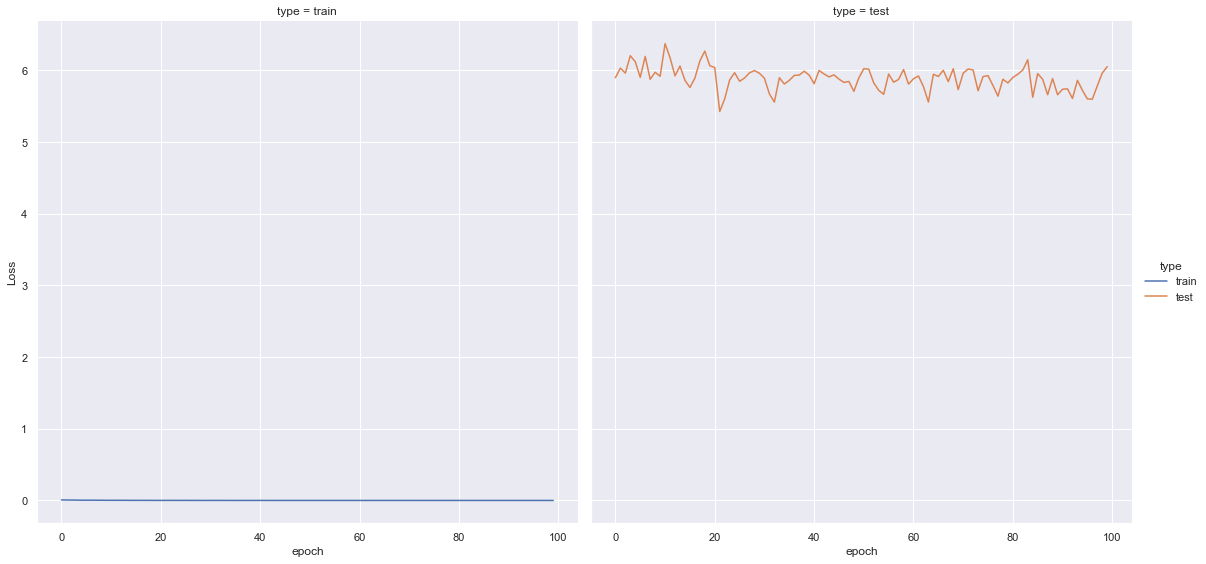

In [120]:
#pd.DataFrame({'':loss_list+loss_list_v})

df_lossgraph = pd.DataFrame({'Loss':(loss_list+[i for i in loss_list_v]),'type':(['train' for i in range(len(loss_list_v))] + ['test' for i in range(len(loss_list_v))]),'epoch':([i for i in range(len(loss_list_v))] + [i for i in range(len(loss_list_v))]) } )



import seaborn as sns
from matplotlib import pyplot as plt

sns.relplot(data = df_lossgraph,x='epoch',y='Loss',col='type',hue='type',kind='line',height=8)



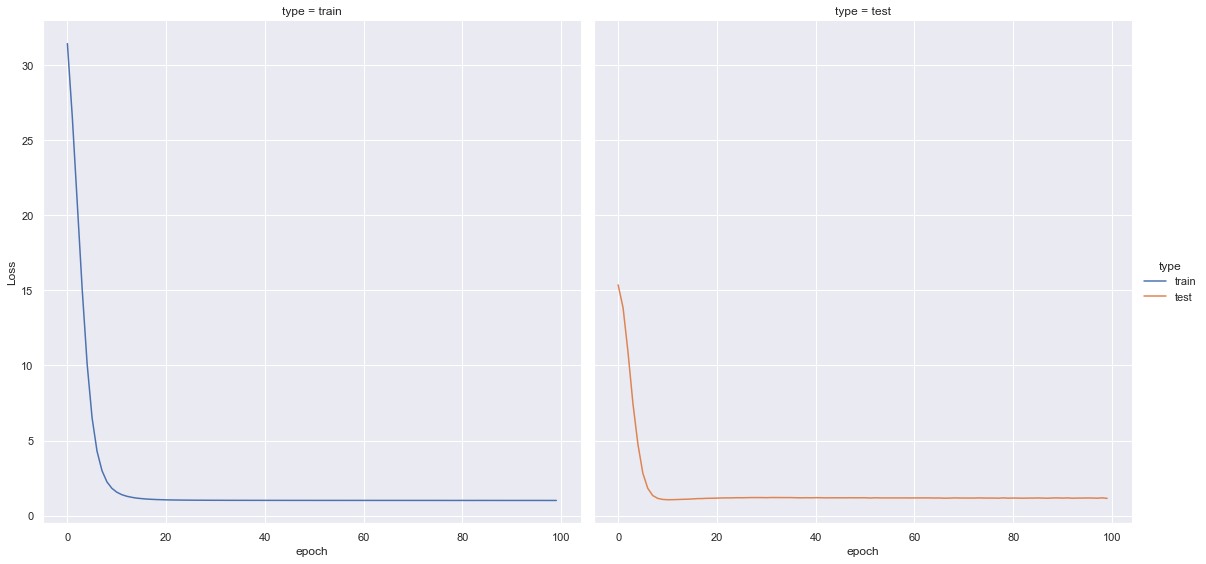

In [116]:
df_lossgraph = pd.DataFrame({'Loss':(loss_listc+[i for i in loss_listc_v]),'type':(['train' for i in range(len(loss_listc_v))] + ['test' for i in range(len(loss_listc_v))]),'epoch':([i for i in range(len(loss_listc_v))] + [i for i in range(len(loss_listc_v))]) } )



import seaborn as sns
from matplotlib import pyplot as plt

sns.relplot(data = df_lossgraph,x='epoch',y='Loss',col='type',hue='type',kind='line',height=8)

In [113]:
df_lossgraph

,Loss,type,epoch
0,31.429863,train,0
1,26.516549,train,1
2,20.800882,train,2
3,15.051672,train,3
4,10.088006,train,4
...,...,...,...
195,-4.825531,test,95
196,-4.828307,test,96
197,-4.840545,test,97
198,-4.818284,test,98


In [121]:

train['keywords_ind'] = [lookup(i) for i in train.keywords.to_list()]
keywords_list_ind_train = train['keywords_ind'].to_list()
def find_embeddings(lists,models):
    total_list = []
    for i,j in enumerate(lists):
        temp_list = lists.copy()
        models.eval()

        try:
            results = models.get_embeddings(torch.tensor([j]).int().to(device))
            total_list.append(results.tolist()[0])
        except:
            total_list.append(models.get_embeddings(torch.tensor([[0]]).int().to(device))[0])
    return total_list
model_c_keywords_emb_train = find_embeddings(keywords_list_ind_train,c_model)
list_keywords_tensor_c_train = torch.tensor(model_c_keywords_emb_train).cuda()
list_keywords_tensor_c_train.shape
list_answer_train = []
for i,j in enumerate(list_keywords_tensor_c_train):
    
    index_print = np.argpartition(( j- list_keywords_tensor_c_train).pow(2).sum(1).sqrt().to('cpu'), 2).numpy()[2]
    

        
    
    list_answer_train.append(index_print)
train['target_y_index'] = list_answer_train
train = train.reset_index(drop=True)
sum(train.y == train.y[train['target_y_index']].reset_index()['y'])/train.shape[0]

0.7488202488202488

In [122]:
def find_embeddings(lists,models):
    total_list = []
    for i,j in enumerate(lists):
        temp_list = lists.copy()
        models.eval()

        try:
            results = models.get_embeddings(torch.tensor([j]).int().to(device))
            total_list.append(results.tolist()[0])
        except:
            total_list.append(models.get_embeddings(torch.tensor([[0]]).int().to(device))[0])
    return total_list
model_s_keywords_emb_train = find_embeddings(keywords_list_ind_train,s_model)
list_keywords_tensor_s_train = torch.tensor(model_s_keywords_emb_train).cuda()
list_keywords_tensor_s_train.shape
list_answer_train = []
for i,j in enumerate(list_keywords_tensor_s_train):
    
    index_print = np.argpartition(( j- list_keywords_tensor_s_train).pow(2).sum(1).sqrt().to('cpu'), 2).numpy()[2]
    

        
    
    list_answer_train.append(index_print)
train['target_y_index_s'] = list_answer_train
train = train.reset_index(drop=True)
sum(train.y == train.y[train['target_y_index_s']].reset_index()['y'])/train.shape[0]

0.7740597740597741

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
y_true = ["cat", "ant", "cat", "cat", "ant", "bird"]
y_pred = ["ant", "ant", "cat", "cat", "ant", "cat"]
confusion_matrix(y_true, y_pred, labels=["ant", "bird", "cat"])
array([[2, 0, 0],
       [0, 0, 1],
       [1, 0, 2]])